In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import gym

In [4]:
from qlearning import DiscretizedObservationWrapper
from qlearning import EpsilonQlearningAgent as EQA
from qlearning import BoltzmannQlearningAgent as BQA
from qlearning import EpsilonSARSAAgent as eSARSA
from qlearning import BoltzmannSARSAAgent as bSARSA

In [11]:
# plot, smoothed data
def plot_with_filter(rewards, avg=10, ax=None):
    # use np.convolve() to do moving average
    rewards_flt = np.convolve(rewards, np.ones(avg), 'valid') / avg
    if ax:
        ax.plot(rewards_flt)
    else:
        plt.plot(rewards_flt)

# discrete observation environments

In [5]:
env_cliffwalk = gym.make("CliffWalking-v0")

In [41]:
eqa = EQA(range(env_cliffwalk.action_space.n))
eqa.fit(env_cliffwalk, nb_episodes=1000)

In [42]:
bqa = BQA(range(env_cliffwalk.action_space.n))
bqa.fit(env_cliffwalk, nb_episodes=1000)

In [43]:
esa = eSARSA(range(env_cliffwalk.action_space.n))
esa.fit(env_cliffwalk, nb_episodes=1000)

In [44]:
bsa = bSARSA(range(env_cliffwalk.action_space.n))
bsa.fit(env_cliffwalk, nb_episodes=1000)

Text(0, 0.5, 'total rewards per episode')

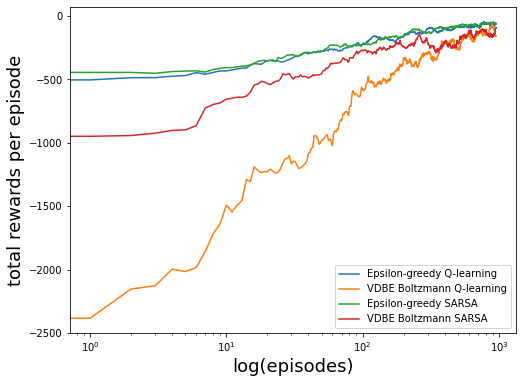

In [45]:
# plot the performance
fig, ax = plt.subplots(1,1, figsize=(8, 6))
plot_with_filter(eqa.rewards, avg=50, ax=ax)
plot_with_filter(bqa.rewards, avg=50, ax=ax)
plot_with_filter(esa.rewards, avg=50, ax=ax)
plot_with_filter(bsa.rewards, avg=50, ax=ax)
ax.legend([
    "Epsilon-greedy Q-learning",
    "VDBE Boltzmann Q-learning",
    "Epsilon-greedy SARSA",
    "VDBE Boltzmann SARSA"
])
ax.set_xscale("log")
ax.set_xlabel("log(episodes)", fontsize=18)
ax.set_ylabel("total rewards per episode", fontsize=18)

# continous observation environment

In [14]:
env_cartpole = DiscretizedObservationWrapper(
    gym.make("CartPole-v0"),
    n_bins = 24,
    low = [-2.4, -2.0, -0.42, -3.5],
    high = [2.4, 2.0, 0.42, 3.5]
)

In [46]:
train_episodes = 10000

In [47]:
eqa = EQA(range(env_cartpole.action_space.n))
eqa.fit(env_cartpole, nb_episodes=train_episodes)

In [48]:
esa = eSARSA(range(env_cartpole.action_space.n))
esa.fit(env_cartpole, nb_episodes=train_episodes)

Text(0, 0.5, 'total rewards per episode')

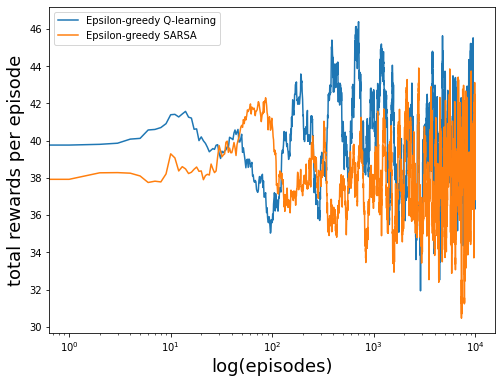

In [50]:
# plot the performance
fig, ax = plt.subplots(1,1, figsize=(8, 6))
plot_with_filter(eqa.rewards, avg=100, ax=ax)
plot_with_filter(esa.rewards, avg=100, ax=ax)
ax.legend([
    "Epsilon-greedy Q-learning",
    "Epsilon-greedy SARSA",
])
ax.set_xscale("log")
ax.set_xlabel("log(episodes)", fontsize=18)
ax.set_ylabel("total rewards per episode", fontsize=18)

Q-learning and SARSA is not good at continous observation environments since 
they have to discretize the observations and save the discretized state-action
Q values.

To see how bad they perform, here we implement Deep Q-network (DQN) and the 
simpliest policy gradient algorithm (REINFORCE) by using tensorflow agents
package.

### DQN

A DQN agent has the following components:
- Q-network, its input dim is determined by the env.observation_space.shape[0]
- experienceReplay, a buffer to store the past experience, has a callback to sample a batch of the experience for training.
- loss function, MSE of the temporal difference
- solver, Adam

In [62]:
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.agents.dqn import dqn_agent
from tf_agents.networks import sequential
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.utils import common

In [63]:
# TF wrapped environment
tf_env = tf_py_environment.TFPyEnvironment(
    suite_gym.load("CartPole-v0")
)

In [64]:
action_spec = tf_env.action_spec()
# Q-network
model = sequential.Sequential([
    tf.keras.layers.Dense(64, activation="relu"), # fc1
    tf.keras.layers.Dense(64, activation="relu"), # fc2
    tf.keras.layers.Dense(
        action_spec.maximum - action_spec.minimum + 1,
        activation = None
    )
])

In [65]:
# optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

In [66]:
# DQN agent
dqna = dqn_agent.DqnAgent(
    tf_env.time_step_spec(),
    tf_env.action_spec(),
    q_network = model,
    optimizer = optimizer,
    td_errors_loss_fn = common.element_wise_squared_loss,
    train_step_counter = tf.Variable(0)
)
dqna.initialize()

In [67]:
# experience replay buffer
buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec = dqna.collect_data_spec,
    batch_size = tf_env.batch_size,
    max_length = 100000
)

In [68]:
# define function to collect experience

def collect_step(env, policy, buffer):
    """one step interaction with env by following the policy"""
    time_step = env.current_time_step()
    action = policy.action(time_step)
    time_step_ = env.step(action)
    traj = trajectory.from_transition(
        time_step, action, time_step_
    )
    buffer.add_batch(traj)
    
def collect_data(env, policy, buffer, steps):
    """data collection"""
    for _ in range(steps):
        collect_step(env, policy, buffer)
        
# test
collect_data(tf_env, dqna.collect_policy, buffer, 100)

In [69]:
# let the agent have the access to buffer

dataset = buffer.as_dataset(
    num_parallel_calls = 3,
    sample_batch_size = 64,
    num_steps = 2,
    single_deterministic_pass = False
).prefetch(3)

iterator = iter(dataset)

# test
iterator.next()

(Trajectory(step_type=<tf.Tensor: shape=(64, 2), dtype=int32, numpy=
 array([[1, 2],
        [2, 0],
        [1, 1],
        [1, 2],
        [1, 2],
        [2, 0],
        [0, 1],
        [2, 0],
        [1, 2],
        [1, 1],
        [0, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 2],
        [1, 1],
        [1, 1],
        [0, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [0, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [0, 1],
        [1, 1],
        [0, 1],
        [1, 2],
        [1, 1],
        [0, 1],
        [2, 0],
        [1, 1],
        [1, 1],
        [2, 0],
        [0, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [0, 1],
        [1, 2],
        [0, 1],
        [1, 1],
        [0, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
   

In [70]:
# define evaluation function

def evaluation(env, policy, nb_episodes=10):
    """get average episodic reward"""
    total_return = 0.0
    for _ in range(nb_episodes):
        ts = env.reset()
        er = 0 # episodic return
        while not ts.is_last(): # done or not
            a = policy.action(ts)
            ts = env.step(a.action)
            er += ts.reward
        total_return += er
        
    avg_return = total_return / nb_episodes
    return avg_return.numpy()[0]

In [71]:
# training

dqna.train = common.function(dqna.train)
dqna.train_step_counter.assign(0)

# performance metric before training
avgr = evaluation(tf_env, dqna.policy, 100)
rewards = [avgr]

for _ in range(10000):
    # collect experience
    collect_data(tf_env, dqna.collect_policy, buffer, 1)
    # sample experience and train
    experience, _ = next(iterator)
    train_loss = dqna.train(experience).loss
    # show process
    step = dqna.train_step_counter.numpy()
    if step % 1000 == 0:
        print('step = {0}: loss = {1}'.format(step, train_loss))
    if step % 1000 == 0:
        avgr = evaluation(tf_env, dqna.policy, 100)
        rewards.append(avgr)
        print('step = {0}: Average Return = {1}'.format(step, avgr))

step = 1000: loss = 97.4554443359375
step = 1000: Average Return = 24.420000076293945
step = 2000: loss = 60.90959930419922
step = 2000: Average Return = 65.5
step = 3000: loss = 217.9246826171875
step = 3000: Average Return = 179.02999877929688
step = 4000: loss = 421.70208740234375
step = 4000: Average Return = 195.7899932861328
step = 5000: loss = 19213.3671875
step = 5000: Average Return = 197.9499969482422
step = 6000: loss = 6864.427734375
step = 6000: Average Return = 198.77999877929688
step = 7000: loss = 34793.30078125
step = 7000: Average Return = 198.47000122070312
step = 8000: loss = 2676.54296875
step = 8000: Average Return = 199.7100067138672
step = 9000: loss = 1075.0087890625
step = 9000: Average Return = 198.5
step = 10000: loss = 6243.5458984375
step = 10000: Average Return = 199.67999267578125


### REINFORCE

customize-implemented.

In [59]:
from reinforce2 import ReinforceAgent

In [60]:
env_cartpole = gym.make("CartPole-v0")

In [61]:
ra = ReinforceAgent(
    env_cartpole.observation_space.shape[0],
    env_cartpole.action_space.n,
)
ra.fit(env_cartpole, nb_episodes=2000, log_interval=100)

episode 0, rewards 40.0
episode 100, rewards 166.2
episode 200, rewards 175.2
episode 300, rewards 195.8
episode 400, rewards 95.8
episode 500, rewards 155.3
episode 600, rewards 177.5
episode 700, rewards 200.0
episode 800, rewards 160.1
episode 900, rewards 72.1
episode 1000, rewards 196.4
episode 1100, rewards 95.8
episode 1200, rewards 161.8
episode 1300, rewards 139.5
episode 1400, rewards 196.8
episode 1500, rewards 200.0
episode 1600, rewards 186.2
episode 1700, rewards 200.0
episode 1800, rewards 188.0
episode 1900, rewards 131.7


### compare

Text(0, 0.5, 'total rewards per episode')

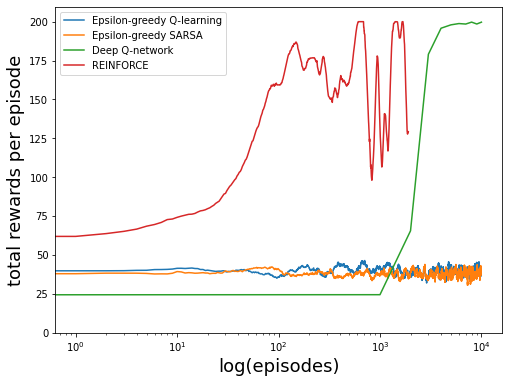

In [73]:
# plot the performance
fig, ax = plt.subplots(1,1, figsize=(8, 6))
plot_with_filter(eqa.rewards, avg=100, ax=ax)
plot_with_filter(esa.rewards, avg=100, ax=ax)
ax.plot(list(range(0, 10001, 1000)), rewards)
plot_with_filter(ra.rewards, avg=100, ax=ax)
ax.legend([
    "Epsilon-greedy Q-learning",
    "Epsilon-greedy SARSA",
    "Deep Q-network",
    "REINFORCE"
])
ax.set_xscale("log")
ax.set_xlabel("log(episodes)", fontsize=18)
ax.set_ylabel("total rewards per episode", fontsize=18)